# Combined projections
While the **Projections** notebook touched upon how to set up simple projections it is more interesting to see how more complex models can be set up and utilized. 
`suppy.projections`contains general implementations for projection methods that allow to find a poin in the intersection of the individual feasible sets. 

These are:
- SequentialProjection
- SimultaneousProjection
- BlockIterativeProjection
- StringAveragedProjection

Each of these projection methods has a `project` function that allows to perform a single feasibility seeking step, as well as a general `solve` function.
While the mathematical formulation of each of the latter three allows for parallel computation the current framework implements them sequentially.

Let's set up a simple model that tries to find a point in the intersection of two halfspaces $H_1$ and $H_2$:

In [1]:
import numpy as np
from suppy.projections import HalfspaceProjection
from suppy.projections import SequentialProjection

In [2]:
a_1 = np.array([1,1])
a_2 = np.array([-1,0])
b_1 = 0
b_2 = 0
Halfspace_1 = HalfspaceProjection(a_1, b_1)
Halfspace_2 = HalfspaceProjection(a_2, b_2)
seq_model = SequentialProjection([Halfspace_1, Halfspace_2])

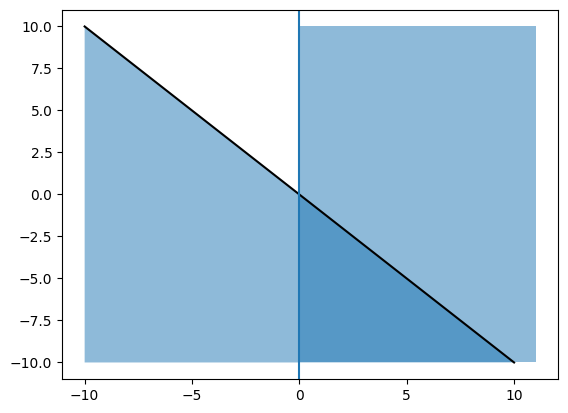

In [3]:
# We can also visualize the model using matplotlib:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
seq_model.visualize(ax)

## Projection
In this case we try to find a point in the above dark blue shaded area.
For this the `SequentialProjection` iteratively projects onto $H_1$ and $H_2$:
\begin{equation}
x_1 = P_{H_2}(P_{H_1}(x_0))
\end{equation}
with $P_{H_i}$ being the projecton onto $H_i$.

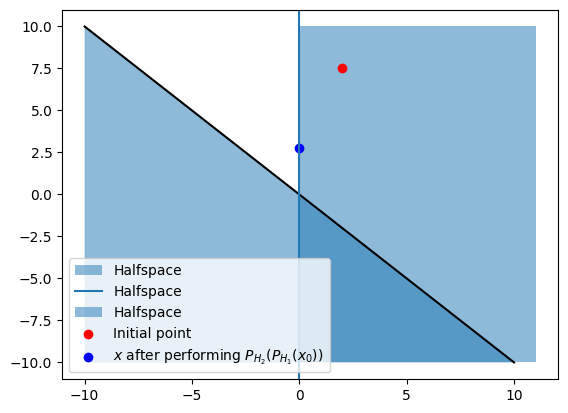

In [4]:
x_0 = np.array([2,7.5])
x_1 = seq_model.project(x_0.copy())
fig,ax = plt.subplots()
seq_model.visualize(ax)
ax.scatter(x_0[0], x_0[1], color='red',label = 'Initial point')
ax.scatter(x_1[0], x_1[1], color='blue', label = '$x$ after performing $P_{H_2}(P_{H_1}(x_0))$')
plt.legend(loc = 'lower left')

## Feasibility seeking
While this does not result in a point in the intersection we can perform this operation several times in a row. For this the `solve` function is used which runs until a stopping criterium is met (In this case that the weighted sum of residuals falls below a lower bound or a maximal number of iterations is performed).
This results in the following feasible point:

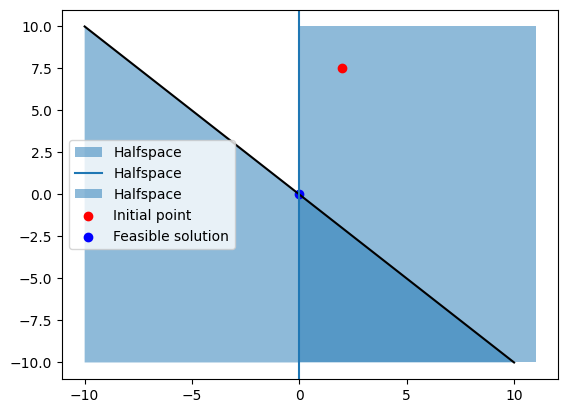

In [5]:
x_0 = np.array([2,7.5])
x_1 = seq_model.solve(x_0.copy(),storage = True)
fig,ax = plt.subplots()
seq_model.visualize(ax)
ax.scatter(x_0[0], x_0[1], color='red',label = 'Initial point')
ax.scatter(x_1[0], x_1[1], color='blue', label = 'Feasible solution')
plt.legend()

Things to note here:
1. The `project` and `solve` method are passed copies of $x_0$. This is due to the `project` function, which is used in all algorithms, **changing the input in place** in a lot of cases.
To still have access to the initial vector afterwards it is therefore recommended to just pass a copy.
2. The solve function has a `storage` option, which is by default deactivated,that allows to store intermediate solutions $x^k$ of the feasibility seeking process.
After termination of the intermediate solutions can be accessed via `model.all_x`
3. The algorithm terminates once the proximity drops below a given threshold. By default the proximity value is calculated as a weighted sum of the proximities to the individual  constraints: (weights are chosen uniformly be default)
\begin{equation}
\sum_i w_i Prox_i(x)^2 \leq Prox_{max}
\end{equation}
4. It is possible to select other proximity measures like a max distance norm. For this a LIST of `proximity_measures` can be passed to the solve function. As of now the following options are available:

    a) `p_norm` distance ($\sum_id(x,C_i)^p$) by passing a tuple `("p_norm",p)` with p being the wanted power (default p=2) 

    b) `max_norm` distance ($\max_i d(x,C_i)$) by simply passing the string `max_norm`

If the passed list contains more than one option all quantities are calculated, however (as of now) only the first one can be chosen for the stopping criterion.

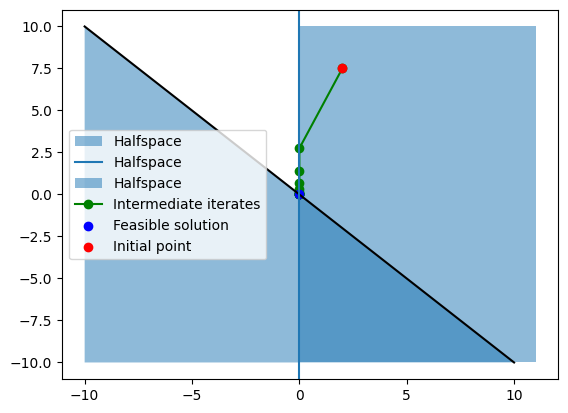

In [6]:
fig,ax = plt.subplots()
seq_model.visualize(ax)
ax.plot(seq_model.all_x[:,0],seq_model.all_x[:,1], '-o', color='green', label = 'Intermediate iterates', zorder = 1)
ax.scatter(x_1[0], x_1[1], color='blue', label = 'Feasible solution')
ax.scatter(x_0[0], x_0[1], color='red',label = 'Initial point')
plt.legend()

## Simultaneous Projection

For the `SimultaneousProjection`, a new value for $x$ is calculated by projecting the current iterate $x^k$ onto each constraint and then performing a convex combination of the individual ones:
\begin{align}
x^{k+1} &= \sum_i{w_i P_i(x^k)}\\
\sum_i{w_i} &= 1
\end{align}
By default weights are chosen to be uniform but can be adapted by setting `weights`.

In [7]:
from suppy.projections import SimultaneousProjection

## Uniform weights

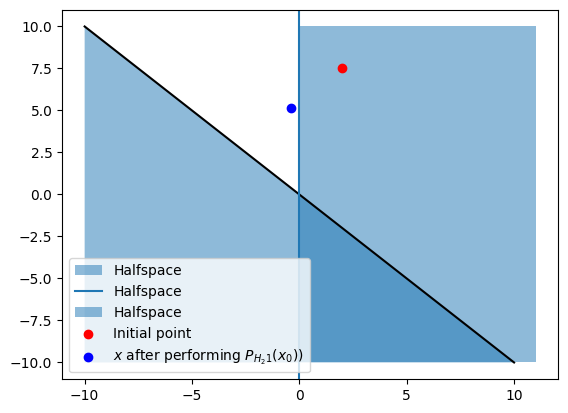

In [8]:
a_1 = np.array([1,1])
a_2 = np.array([-1,0])
b_1 = 0
b_2 = 0
Halfspace_1 = HalfspaceProjection(a_1, b_1)
Halfspace_2 = HalfspaceProjection(a_2, b_2)
sim_model_1 = SimultaneousProjection([Halfspace_1, Halfspace_2])
x_1 = sim_model_1.project(x_0.copy())
fig,ax = plt.subplots()
sim_model_1.visualize(ax)
ax.scatter(x_0[0], x_0[1], color='red',label = 'Initial point')
ax.scatter(x_1[0], x_1[1], color='blue', label = '$x$ after performing $P_{H_21}(x_0))$')
plt.legend(loc = 'lower left')

## With different weights 

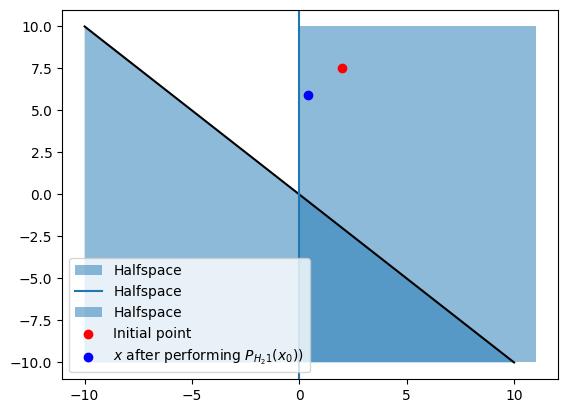

In [9]:
a_1 = np.array([1,1])
a_2 = np.array([-1,0])
b_1 = 0
b_2 = 0
Halfspace_1 = HalfspaceProjection(a_1, b_1)
Halfspace_2 = HalfspaceProjection(a_2, b_2)
sim_model_2 = SimultaneousProjection([Halfspace_1, Halfspace_2],weights = np.array([1/3,2/3]))
x_1 = sim_model_2.project(x_0.copy())
fig,ax = plt.subplots()
sim_model_2.visualize(ax)
ax.scatter(x_0[0], x_0[1], color='red',label = 'Initial point')
ax.scatter(x_1[0], x_1[1], color='blue', label = '$x$ after performing $P_{H_21}(x_0))$')
plt.legend(loc = 'lower left')

Since one of the constraints is already met, only the other one affects the projection. With the weight being only $1/3$ the new iterate is different to the uniform weights.

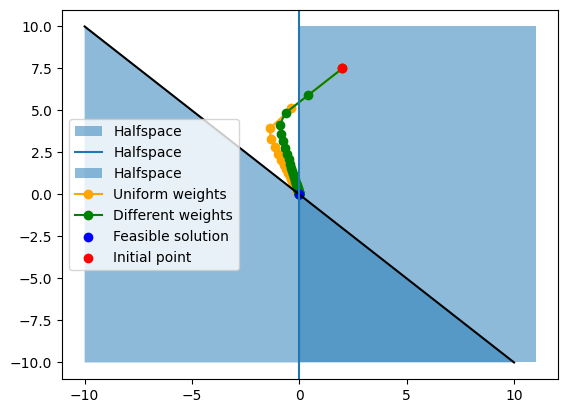

In [10]:
x_sim_1 = sim_model_1.solve(x_0.copy(),storage = True)
x_sim_2 = sim_model_2.solve(x_0.copy(),storage = True)
fig,ax = plt.subplots()
sim_model_2.visualize(ax)
ax.plot(sim_model_1.all_x[:,0],sim_model_1.all_x[:,1], '-o', color='orange', label = 'Uniform weights', zorder = 1)
ax.plot(sim_model_2.all_x[:,0],sim_model_2.all_x[:,1], '-o', color='green', label = 'Different weights', zorder = 1)
ax.scatter(x_sim_1[0], x_sim_1[1], color='blue', label = 'Feasible solution')
ax.scatter(x_0[0], x_0[1], color='red',label = 'Initial point')
plt.legend()

In case that the constraints can be modelled as linear equations, especially if the size of the system increases by a lot it is more efficient to use a dedicated implementation for these linear algorithms. On how this is handled in **SupPy** check out the `linear_feasible_models` notebook.